## Jonathan Bunch
## Project Milestone 3
## 4 May 2021

### For this milestone I will be working with voter registration data from the Florida Department of State.
### The table contained on this website provides the number of registered voters for each party in each county.
https://dos.myflorida.com/elections/data-statistics/voter-registration-statistics/voter-registration-reportsxlsx/voter-registration-by-county-and-party/

I will begin by using the BeautifulSoup library to parse the html document and extract the desired data.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Open the html file and use the BeautifulSoup library to read in the html structure and contents.
with open("fl_voter_registration_march_2021.html", "r") as s:
    html_data = BeautifulSoup(s, features="html.parser")

# I would expect to find only one table on this website, but I will use find_all() and check the length to make sure.
print(f"Number of tables: {len(html_data.find_all('table'))}")

# Since we know there is indeed only one table, we can use the find() method which extracts only the first occurrence.
voter_table_raw = html_data.find("table")

# Extract the headers from the table using the find_all() method to find all 'th' tags.
voter_headers_raw = [th.getText() for th in voter_table_raw.find_all('th')]
# Check that we got the expected results.
print(f"List of table headers: {voter_headers_raw}")

# Now we can extract the data from the table. I will start by creating a list of all data rows.
voter_data_rows = [tr for tr in voter_table_raw.find_all('tr')[1:]]
# Then extract the text from each data point, row-wise, to create a nested list of values within a list of rows.
voter_data_by_row = [[td.getText() for td in tr.find_all('td')] for tr in voter_data_rows]
# Finally, combine the headers and data into a data frame and check the results.
voter_df_raw = pd.DataFrame(voter_data_by_row, columns=voter_headers_raw)
voter_df_raw.head()

Number of tables: 1
List of table headers: ['County', 'Republican Party Of Florida', 'Florida Democratic Party', 'Minor Party', 'No Party Affiliation', 'Totals']


,County,Republican Party Of Florida,Florida Democratic Party,Minor Party,No Party Affiliation,Totals
0,ALACHUA,"51,428","94,991","3,012","43,890","193,321"
1,BAKER,"10,702","4,420",172,"2,017","17,311"
2,BAY,"67,625","29,906","2,531","27,278","127,340"
3,BRADFORD,"9,578","5,476",174,"2,679","17,907"
4,BREVARD,"193,203","138,446","10,317","115,936","457,902"


Now that we have the data imported and roughly organized, I can begin exploring it and decide how best to proceed with cleaning and formatting.

In [43]:
# View some basic descriptive information about the data frame.
print(f"{voter_df_raw.info} \n {voter_df_raw.info(verbose=True)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   County                       68 non-null     object
 1   Republican Party Of Florida  68 non-null     object
 2   Florida Democratic Party     68 non-null     object
 3   Minor Party                  68 non-null     object
 4   No Party Affiliation         68 non-null     object
 5   Totals                       68 non-null     object
dtypes: object(6)
memory usage: 3.3+ KB
<bound method DataFrame.info of         County Republican Party Of Florida Florida Democratic Party  \
0      ALACHUA                      51,428                   94,991   
1        BAKER                      10,702                    4,420   
2          BAY                      67,625                   29,906   
3     BRADFORD                       9,578                    5,476   
4      BREVARD 

This information reveals several things that stand out to me as needing attention: column names, data types, commas in
numerical values, inconsistent county name formatting, and the bottom "Totals" row.

I will start with the simplest issue to fix: the final "Totals" row. Having a totals column is fine, but as a row is
unnecessary and likely to cause confusion. We could easily calculate those values if we need them anyway, so I will
just remove that row.

In [44]:
# We can use the drop() method to remove the row by index.
voter_sub_1 = voter_df_raw.drop(67)

Next, I will address the column names. Some have spaces and they use title casing; I will replace them
with versions that match my preferred format (lower case letters, integers, and underscores only).

In [45]:
# View the original column names again so I can be sure to preserve the order.
print(f"Original column names:\n{voter_sub_1.columns}\n")
# Create a list of the new names I chose.
voter_col_names = ['county', 'republican', 'democrat', 'minor_party', 'no_party', 'totals']
print(f"New column names:\n{voter_col_names}\n")
# Create a renaming map from the original and replacement column names.
col_name_dict = dict(zip(voter_sub_1.columns, voter_col_names))
# Replace the orginal column names with the new ones.
voter_sub_2 = voter_sub_1.rename(columns=col_name_dict)
# Check the results.
print(voter_sub_2.head())
# View the data frame info again.
voter_sub_2.info()

Original column names:
Index(['County', 'Republican Party Of Florida', 'Florida Democratic Party',
       'Minor Party', 'No Party Affiliation', 'Totals'],
      dtype='object')

New column names:
['county', 'republican', 'democrat', 'minor_party', 'no_party', 'totals']

     county republican democrat minor_party no_party   totals
0   ALACHUA     51,428   94,991       3,012   43,890  193,321
1     BAKER     10,702    4,420         172    2,017   17,311
2       BAY     67,625   29,906       2,531   27,278  127,340
3  BRADFORD      9,578    5,476         174    2,679   17,907
4   BREVARD    193,203  138,446      10,317  115,936  457,902
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 66
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county       67 non-null     object
 1   republican   67 non-null     object
 2   democrat     67 non-null     object
 3   minor_party  67 non-null     object
 4   no_

Next, we need to address some of the string formatting issues in the values. Most importantly, I need to remove the
commas in the numerical values. These will prevent Python from converting those values to a numerical data type.
A simple string formatting function, applied to the numerical columns, should be able to solve this problem.

I also want to modify the county names to match my desired format. I could apply a different function to this column,
but in this case there is actually no reason not to use a single function to fix the names and the numerical values.

In [46]:
# This function will remove commas and the other unwanted special characters, change all casing to lower, and replace
# spaces with underscores.
def format_vals(name):
    name = name.lower()
    name = name.replace(',', '').replace('.', '').replace(' ', '_').replace('-', '_')
    return name


# I will use the applymap() method to apply this function to the entire data frame.
voter_sub_2 = voter_sub_2.applymap(format_vals)
print(voter_sub_2.head())

     county republican democrat minor_party no_party  totals
0   alachua      51428    94991        3012    43890  193321
1     baker      10702     4420         172     2017   17311
2       bay      67625    29906        2531    27278  127340
3  bradford       9578     5476         174     2679   17907
4   brevard     193203   138446       10317   115936  457902


Next, I will address the data types. We can see from the .info() call earlier that the columns are all currently
object data types. I explored several methods for modifying the data types, and decided to go with the astype() method.
This method can accept a dictionary of the format {column:dtype} as a map of data type assignments for each column.

In [47]:
# Create the map of column names to desired data types.
dtype_map = dict(zip(voter_col_names, ['string', 'int64', 'int64', 'int64', 'int64', 'int64']))
# Assign the new data types.
voter_sub_2 = voter_sub_2.astype(dtype_map)
# Check the results.
voter_sub_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 66
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county       67 non-null     string
 1   republican   67 non-null     int64 
 2   democrat     67 non-null     int64 
 3   minor_party  67 non-null     int64 
 4   no_party     67 non-null     int64 
 5   totals       67 non-null     int64 
dtypes: int64(5), string(1)
memory usage: 3.7 KB


Finally, I will check for any NA values, duplicates values, or obvious discrepancies in the descriptive
statistics. I will also make a box plot to help visualize extreme values.

Check for NAs:
county         0
republican     0
democrat       0
minor_party    0
no_party       0
totals         0
dtype: int64

number of unique values:
county         67
republican     67
democrat       67
minor_party    66
no_party       67
totals         67
dtype: int64
if all values are unique, this should match the number of rows: 67

          republican       democrat   minor_party       no_party        totals
count      67.000000      67.000000     67.000000      67.000000  6.700000e+01
mean    77399.164179   78962.164179   3688.179104   57195.074627  2.172446e+05
std     90537.984892  133886.588603   5189.627113   92190.915562  3.158817e+05
min      1681.000000    1177.000000      8.000000     322.000000  4.521000e+03
25%      7621.500000    5845.000000    179.500000    2697.500000  1.761000e+04
50%     51428.000000   27408.000000   1569.000000   23518.000000  1.085690e+05
75%    117306.000000   92269.000000   4049.000000   64437.000000  2.550755e+05
max    429654.000000  6

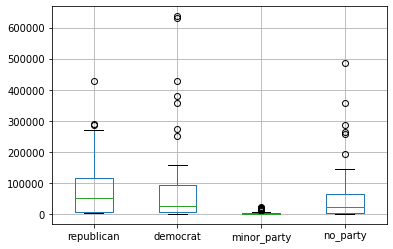

In [48]:
print(f"Check for NAs:\n{voter_sub_2.isna().sum()}\n")
print(f"number of unique values:\n{voter_sub_2.nunique()}")
print(f"if all values are unique, this should match the number of rows: {len(voter_sub_2.county)}\n")
print(voter_sub_2.describe())

# Create a box plot of polital party variables.
voter_sub_2.boxplot(column=list(voter_sub_2.columns[1:5]))
plt.show()

It looks like we don't have any NA values to worry about in this data set.

There is one duplicate value in the "minor_party" column. I would not expect duplicate values in any of the
political party columns to be an issue, since there is no reason to believe there could not be the same number of people
registered to a particular party in more than one different place. The only column where duplicates would indicate an
issue would be the "county" column, since there should only be one record for each county.

The boxplot does reveal some extreme values, but in this context I would not expect them to be problematic. Different
counties can have significantly different sizes, populations, and demographics, so it makes sense that some densely
populated counties could have a much larger number of registered voters.

I also noticed a very small minimum value in the 'minor_party' column (8 registered voters in Liberty county). Again,
there is no reason to believe very small values are incorrect or erroneous in this context.  However, it does mean that
we have very small sample sizes for these groups. I will keep the data as-is for now, but this could be an important
consideration moving forward.